In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size,run_i,rand_seed
0,uci wine example,Stan panel model,0.418302,0.418498,0.834750,0.325675,100,100,6497,6017,0,518677876
1,uci wine example,logistic model,0.435503,0.436348,0.842612,0.416365,100,100,6497,6017,0,518677876
2,uci wine example,Stan comparisons model,0.426839,0.427453,0.841237,0.321151,100,100,6497,6017,0,518677876
3,uci wine example,observed score,0.500823,0.499834,0.850375,0.424080,100,100,6497,6017,0,518677876
4,uci wine example,Stan panel model,0.386790,0.382746,0.799813,inf,100,100,6497,6025,1,1451336747
...,...,...,...,...,...,...,...,...,...,...,...,...
75,uci wine example,observed score,0.522425,0.520198,0.880725,0.420636,100,100,6497,6015,18,566571108
76,uci wine example,Stan panel model,0.447565,0.448096,0.817775,0.349127,100,100,6497,6014,19,364254565
77,uci wine example,logistic model,0.455365,0.454713,0.820600,0.417784,100,100,6497,6014,19,364254565
78,uci wine example,Stan comparisons model,0.457300,0.456869,0.822175,0.359463,100,100,6497,6014,19,364254565


In [3]:
n_draws = int(np.max(d['run_i']) + 1)

In [4]:
d_SpearmanR = d.melt(
    id_vars=['example_name', 'estimate_name'],
    value_vars=['SpearmanR_all', 'SpearmanR_test'],
    var_name='measurement',
    value_name='Spearman R',
)

d_SpearmanR

,example_name,estimate_name,measurement,Spearman R
0,uci wine example,Stan panel model,SpearmanR_all,0.418302
1,uci wine example,logistic model,SpearmanR_all,0.435503
2,uci wine example,Stan comparisons model,SpearmanR_all,0.426839
3,uci wine example,observed score,SpearmanR_all,0.500823
4,uci wine example,Stan panel model,SpearmanR_all,0.386790
...,...,...,...,...
155,uci wine example,observed score,SpearmanR_test,0.520198
156,uci wine example,Stan panel model,SpearmanR_test,0.448096
157,uci wine example,logistic model,SpearmanR_test,0.454713
158,uci wine example,Stan comparisons model,SpearmanR_test,0.456869


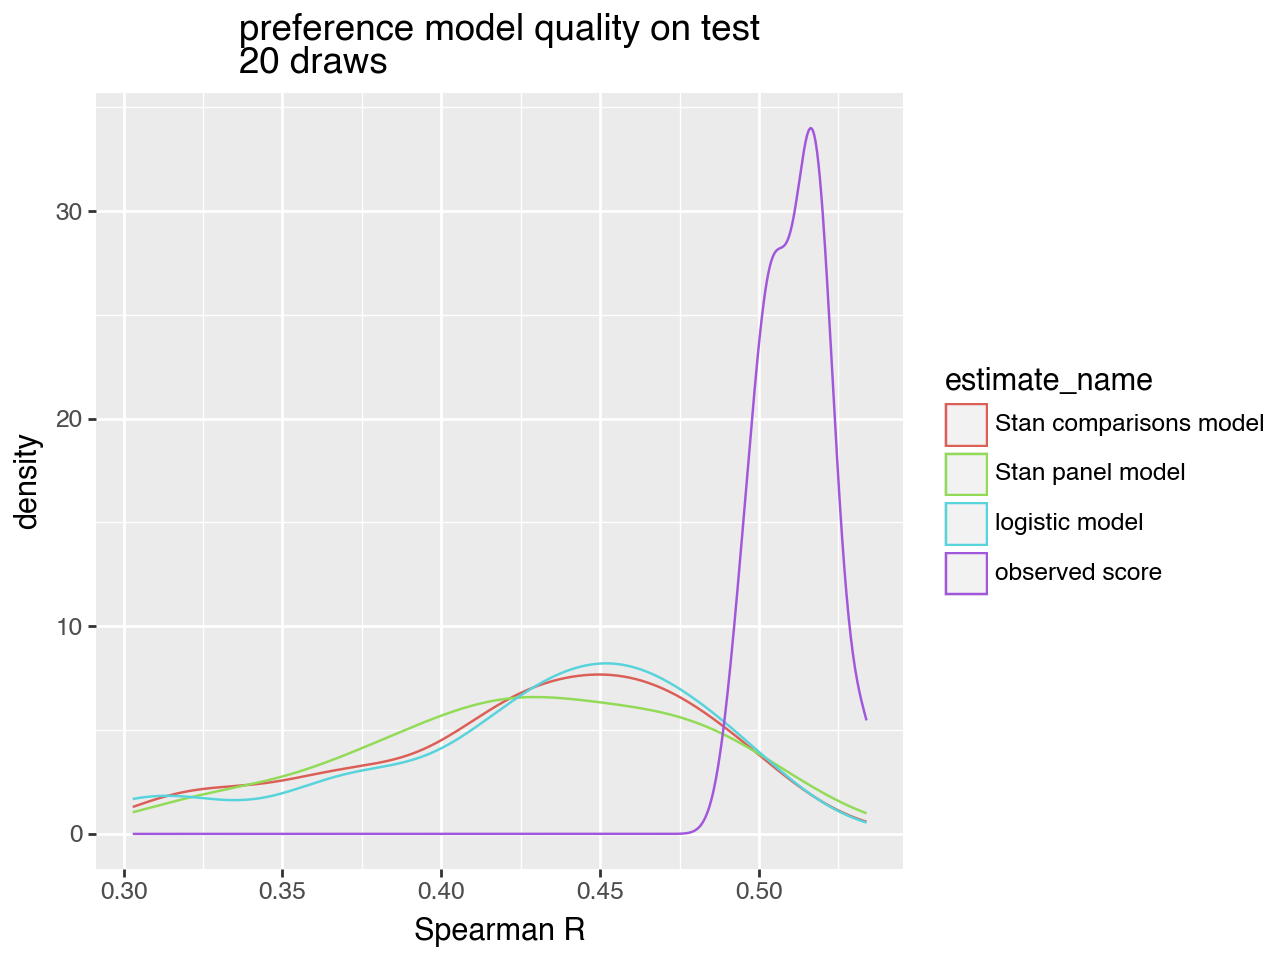

In [5]:
(
    ggplot(
        data=d_SpearmanR.loc[d_SpearmanR['measurement'] == 'SpearmanR_test', :],
        mapping=aes(
            x='Spearman R',
            color='estimate_name',
        )
    )
    + geom_density()
    + ggtitle(f"preference model quality on test\n{n_draws} draws")
)

In [6]:
estimate_names = sorted(set(d['estimate_name']))

estimate_names

['Stan comparisons model',
 'Stan panel model',
 'logistic model',
 'observed score']

Stan comparisons model


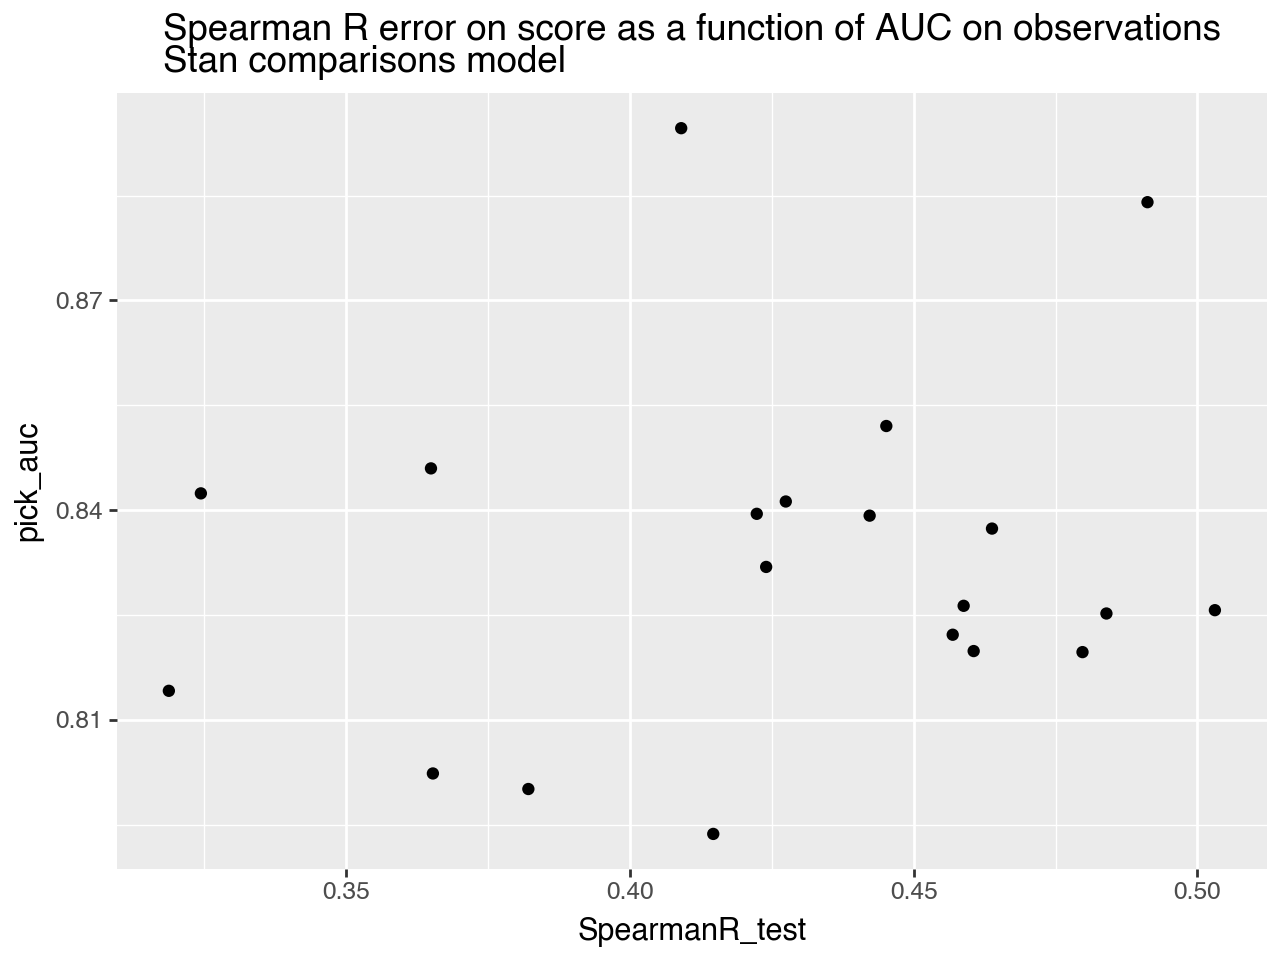

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.5202
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.480
Time:                        16:06:53   Log-Likelihood:                 31.177
No. Observations:                  20   AIC:                            -58.35
Df Residuals:                      18   BIC:                            -56.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1295      0.413      0.314      0.757      -0.737       0.996
pick_auc       0.3571      0.495      0.721      0.480      -0.683       1.397
==============================================================================
Omnibus:                        1.726   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.422   Jarque-Bera (JB):                1.422
Skew:                          -0.603   Prob(JB):                        0.491
Kurtosis:                       2.497   Cond. No.                         69.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Stan panel model


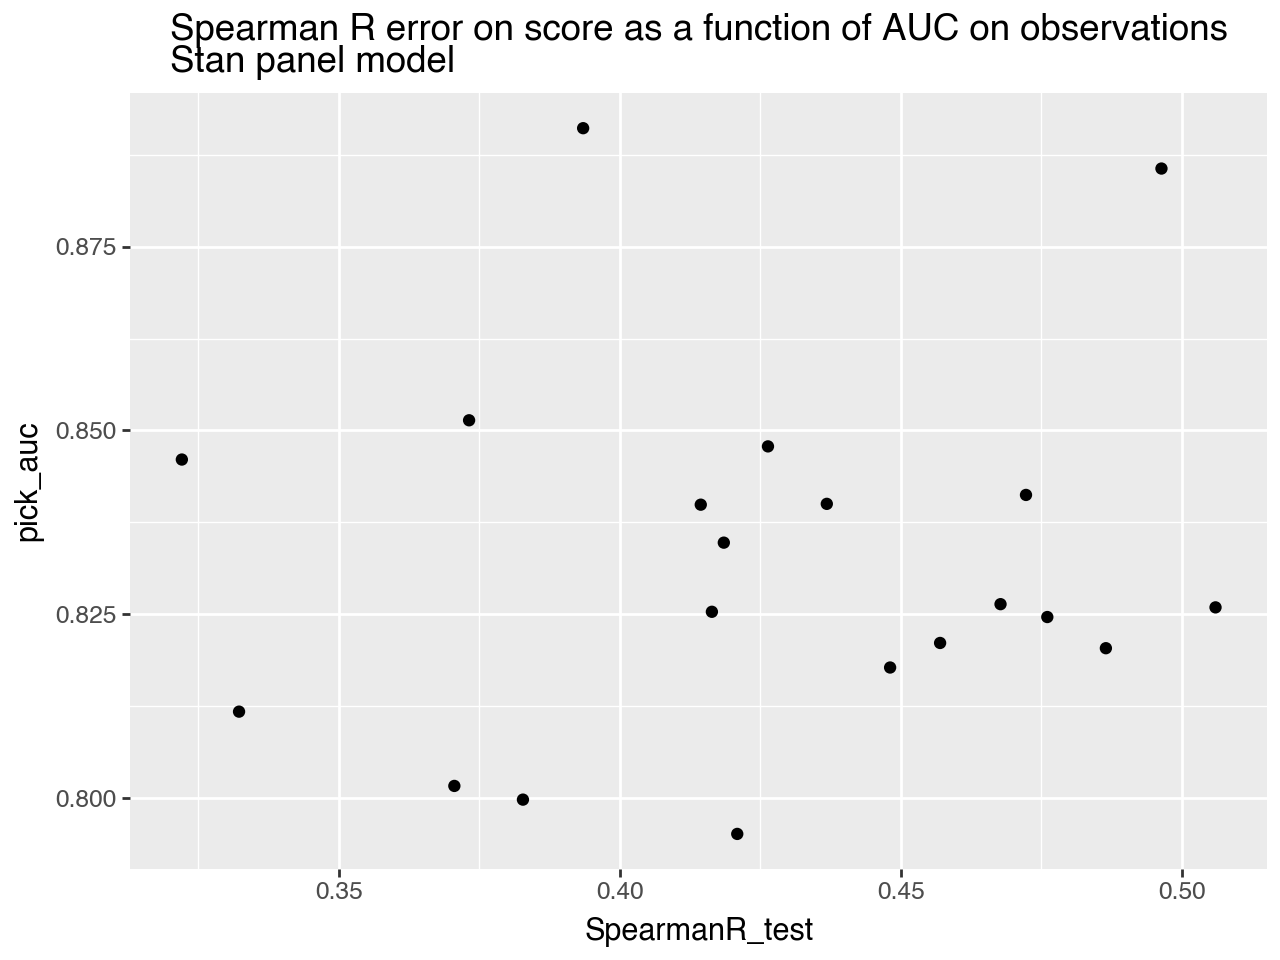

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.1958
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.663
Time:                        16:06:53   Log-Likelihood:                 31.313
No. Observations:                  20   AIC:                            -58.63
Df Residuals:                      18   BIC:                            -56.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2448      0.409      0.598      0.557      -0.615       1.105
pick_auc       0.2176      0.492      0.443      0.663      -0.815       1.250
==============================================================================
Omnibus:                        0.909   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                0.885
Skew:                          -0.389   Prob(JB):                        0.643
Kurtosis:                       2.325   Cond. No.                         69.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

logistic model


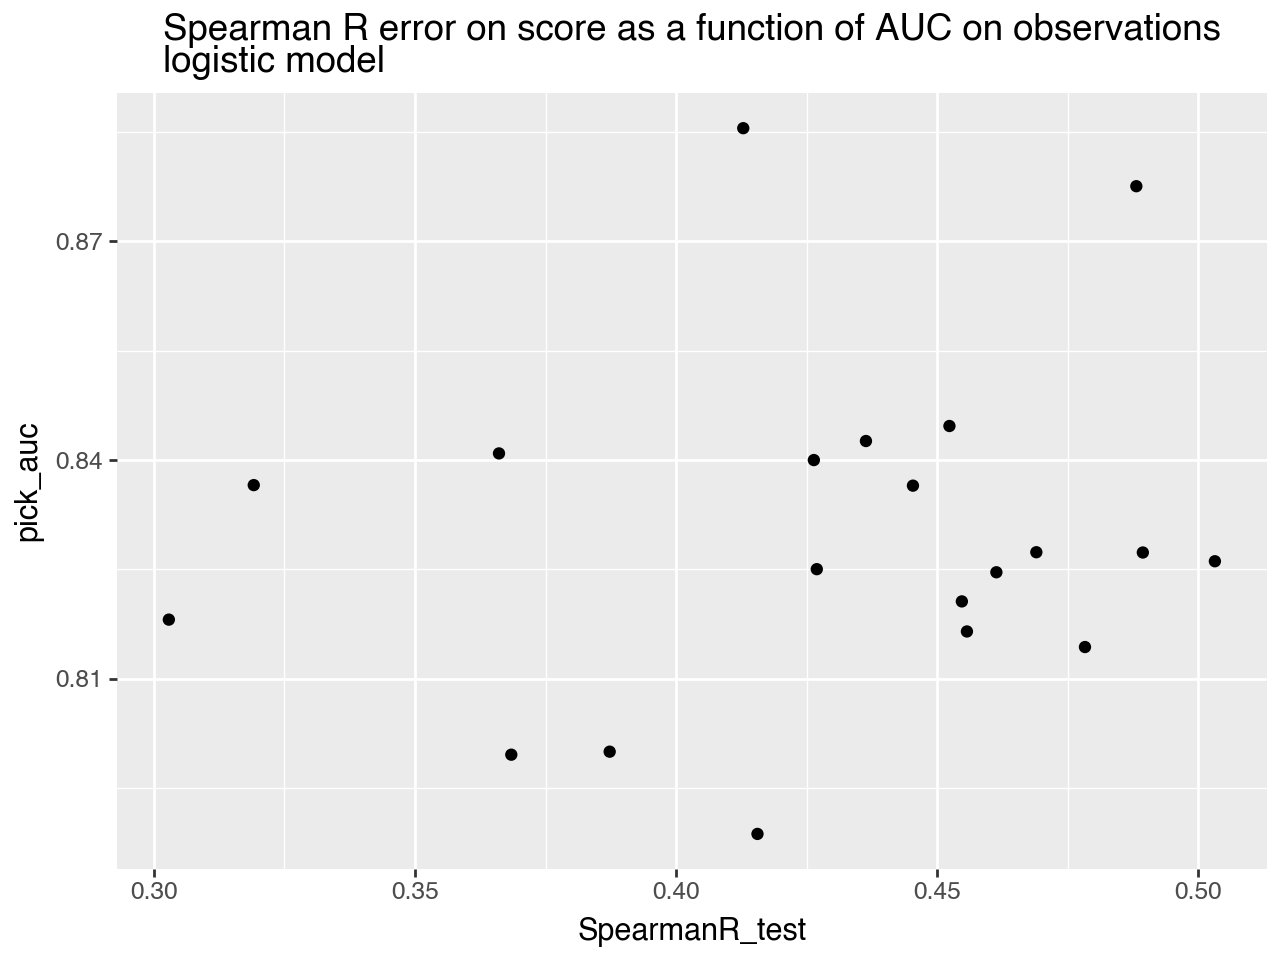

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.5163
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.482
Time:                        16:06:53   Log-Likelihood:                 30.380
No. Observations:                  20   AIC:                            -56.76
Df Residuals:                      18   BIC:                            -54.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1000      0.457      0.219      0.829      -0.859       1.059
pick_auc       0.3953      0.550      0.719      0.482      -0.761       1.551
==============================================================================
Omnibus:                        3.403   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                2.333
Skew:                          -0.836   Prob(JB):                        0.312
Kurtosis:                       2.937   Cond. No.                         74.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

observed score


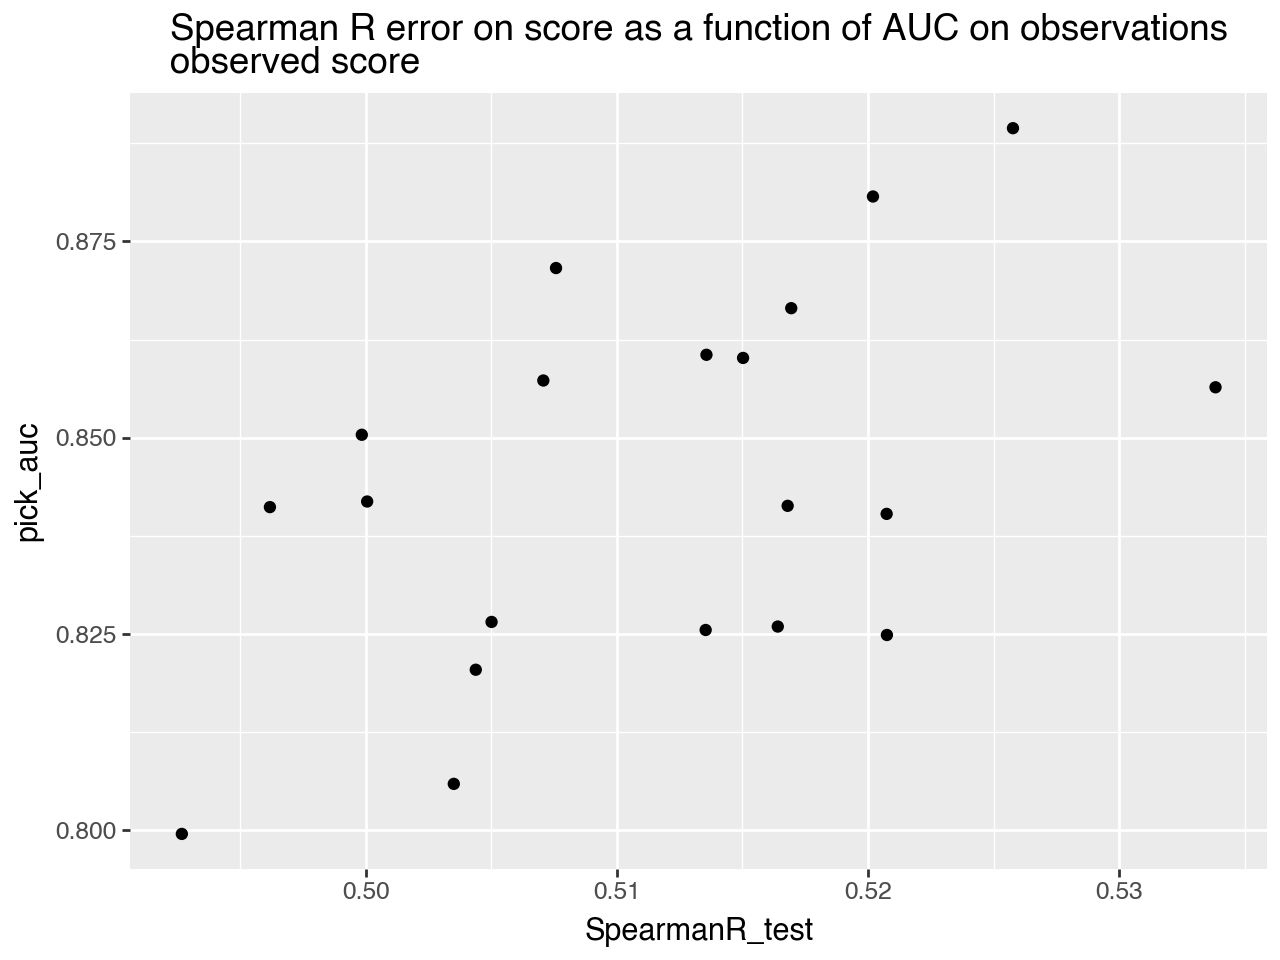

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     5.737
Date:                Mon, 26 Aug 2024   Prob (F-statistic):             0.0277
Time:                        16:06:54   Log-Likelihood:                 65.997
No. Observations:                  20   AIC:                            -128.0
Df Residuals:                      18   BIC:                            -126.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3296      0.076      4.337      0.000       0.170       0.489
pick_auc       0.2155      0.090      2.395      0.028       0.026       0.404
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.468
Skew:                           0.258   Prob(JB):                        0.791
Kurtosis:                       2.457   Cond. No.                         73.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
for estimate_name in estimate_names:
    di = d.loc[d['estimate_name'] == estimate_name, :]
    print(estimate_name)
    (
        ggplot(
            data=di,
            mapping=aes(x='SpearmanR_test', y='pick_auc')
        )
        + geom_point()
        + ggtitle(f"Spearman R error on score as a function of AUC on observations\n{estimate_name}")
    ).show()
    model = ols(
        'SpearmanR_test ~ pick_auc',
        data=di,
    ).fit()
    display(model.summary())